# MLP - Multilayer Perceptron vs. Convolutional Neural Network

Iremos utilizar dois modelos com o mesmo dataset para verificar os diferentes desempenhos do mesmo. 

## Preparo dos Dados:

Vamos adicionar um pouco de translação as imagens do dataset:

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random

In [2]:
def transform_imagens(X, borda):
    novoX = torch.zeros(1, 28 + 2*borda, 28 + 2*borda)
    inicio_h = random.randint(0, 2 * borda)
    inicio_v = random.randint(0, 2 * borda)
    novoX[0, inicio_h:(inicio_h + 28), inicio_v:(inicio_v + 28)] = X[0].view(28, 28)
    return novoX

def carrega_imagens_mnist(file_path, borda=28, transformar=True):
    data = pd.read_csv(file_path)

    rotulos = data['label'].values
    imagens = data.drop(columns=['label']).values

    if transformar:
        imagens_transformadas = []

        for img in imagens:
            imagem_tensor = torch.tensor(img, dtype=torch.float).view(1, 28, 28)
            imagem_transformada = transform_imagens(imagem_tensor, borda)
            imagem_transformada = imagem_transformada / 255.0
            imagens_transformadas.append(imagem_transformada)


        imagens_tensor = torch.stack(imagens_transformadas)
    else:
        imagens_tensor = torch.tensor(imagens, dtype=torch.float).view(-1, 1, 28, 28) / 255.0

    imagens_tensor = imagens_tensor
    rotulos_tensor = torch.tensor(rotulos, dtype=torch.long)

    return imagens_tensor, rotulos_tensor

In [3]:
path_treino = 'datasets/fashion-mnist_train.csv'
path_teste = 'datasets/fashion-mnist_test.csv'

dados_treino, rotulos_treino = carrega_imagens_mnist(path_treino)
dados_teste, rotulos_teste = carrega_imagens_mnist(path_teste)

In [4]:
dados_treino_og, _ = carrega_imagens_mnist(path_treino, transformar=False)
dados_teste_og, _ = carrega_imagens_mnist(path_teste, transformar=False)

In [5]:
def plot_imagens(imagens, num_colunas=5, scale=0.5):
    num_imagens = len(imagens)
    num_linhas = (num_imagens + num_colunas - 1) // num_colunas

    fig, axes = plt.subplots(num_linhas, num_colunas, figsize=(num_colunas * scale, num_linhas * scale))
    axes = axes.flatten()

    for i, (img, ax) in enumerate(zip(imagens, axes)):
        ax.imshow(img.numpy().squeeze(), cmap='inferno')
        ax.axis('off')  # Remove os eixos para uma visualização mais limpa

    for ax in axes[num_imagens:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([60000, 1, 84, 84])
torch.Size([1, 84, 84])


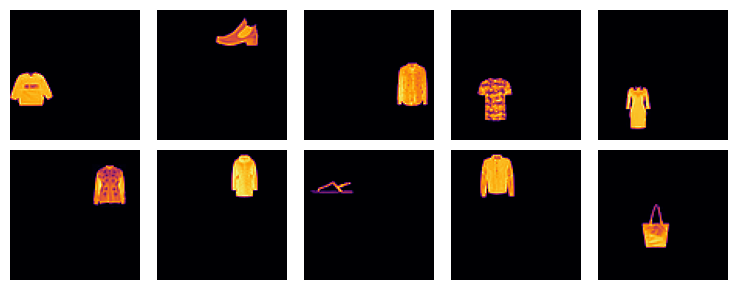

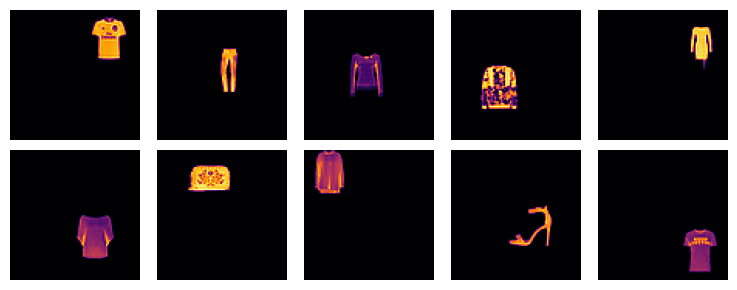

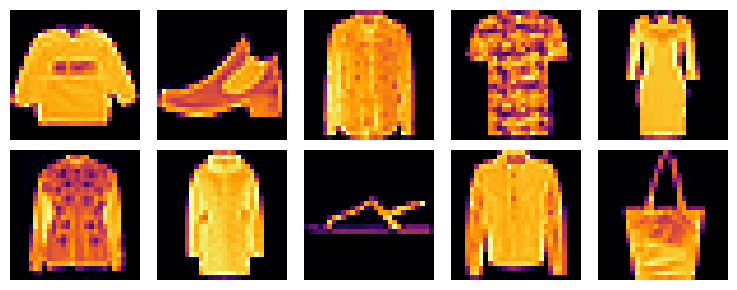

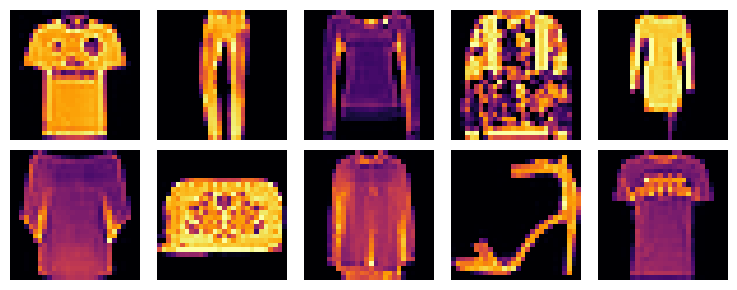

In [6]:
print(dados_treino.shape)
print(dados_treino[0].shape)
plot_imagens(dados_treino[:10].cpu(), num_colunas=5, scale=1.5)
plot_imagens(dados_teste[:10].cpu(), num_colunas=5, scale=1.5)
plot_imagens(dados_treino_og[:10].cpu(), num_colunas=5, scale=1.5)
plot_imagens(dados_teste_og[:10].cpu(), num_colunas=5, scale=1.5)

## MLP - Definições do Modelo:

### Definição das Camadas:

Estamos abaixo definindo as 3 camadas:

Camada 1:
$$
W_1 \in \mathbb{R}^{7056 \times 128} \\ 
b_1 \in \mathbb{R}^{128} 
$$
Camada 2:
$$
W_2 \in \mathbb{R}^{128 \times 64} \\
 b_2 \in \mathbb{R}^{64} \\
$$
Camada 3:
$$
W_3 \in \mathbb{R}^{64 \times 10} \\
b_3 \in \mathbb{R}^{10}
$$

In [7]:
import torch.nn as nn

tamanho_entrada = 84 * 84
camada_oculta1 = 128
camada_oculta2 = 64
camada_saida = 10

camada1 = nn.Linear(tamanho_entrada, camada_oculta1)
camada2 = nn.Linear(camada_oculta1, camada_oculta2)
camada3 = nn.Linear(camada_oculta2, camada_saida)

Para acessar os vetores de peso, podemos:

In [8]:
print(camada1.weight.shape)
print(camada1.bias.shape)
print(camada2.weight.shape)
print(camada2.bias.shape)
print(camada3.weight.shape)
print(camada3.bias.shape)

torch.Size([128, 7056])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


### Classe do Modelo:

In [9]:
class MLP(nn.Module):
    def __init__(self, tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida):
        super(MLP, self).__init__()
        self.camada1 = nn.Linear(tamanho_entrada, camada_oculta1)
        self.camada2 = nn.Linear(camada_oculta1, camada_oculta2)
        self.camada3 = nn.Linear(camada_oculta2, camada_saida)

        self.sigmoid = nn.ReLU()

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.sigmoid(self.camada1(X))
        X = self.sigmoid(self.camada2(X))
        X = self.camada3(X)
        return X

### Função de Perda e Otimizador:

## Treinamento:

In [18]:
def acuracia(saidas, rotulos):
    _, predicao = torch.max(saidas, 1)
    return (predicao == rotulos).sum().item() / len(predicao)

def teste(modelo, dados_teste, rotulos_teste):
    modelo.eval()
    saidas = modelo(dados_teste)
    acc = acuracia(saidas, rotulos_teste)
    print(f'Acurácia: {acc}')


def treino(modelo, otimizador, perda, dados, num_epocas = 10):
    lista_perdas = []
    acuracias = []

    for epoca in range(num_epocas):
        modelo.train()
        otimizador.zero_grad()

        saidas = modelo(dados)
        acc = acuracia(saidas, rotulos_treino)
        acuracias.append(acc)
        erro = perda(saidas, rotulos_treino)

        erro.backward()
        otimizador.step()
        lista_perdas.append(erro.item())
        print(f'Epoca {epoca+1}/{num_epocas}, Perda: {erro.item()}, Acc: {acc}')

    return lista_perdas, acuracias


Epoca 1/50, Perda: 2.302457809448242, Acc: 0.10051666666666667
Epoca 2/50, Perda: 2.704345226287842, Acc: 0.1
Epoca 3/50, Perda: 2.3943960666656494, Acc: 0.10781666666666667
Epoca 4/50, Perda: 2.3093173503875732, Acc: 0.1258
Epoca 5/50, Perda: 2.2754902839660645, Acc: 0.1413
Epoca 6/50, Perda: 2.2448740005493164, Acc: 0.17955
Epoca 7/50, Perda: 2.207639217376709, Acc: 0.20071666666666665
Epoca 8/50, Perda: 2.1594176292419434, Acc: 0.20916666666666667
Epoca 9/50, Perda: 2.1002166271209717, Acc: 0.2135
Epoca 10/50, Perda: 2.0285823345184326, Acc: 0.23136666666666666
Epoca 11/50, Perda: 1.9510329961776733, Acc: 0.2503166666666667
Epoca 12/50, Perda: 1.8657842874526978, Acc: 0.27416666666666667
Epoca 13/50, Perda: 1.776116967201233, Acc: 0.3080833333333333
Epoca 14/50, Perda: 1.6927272081375122, Acc: 0.34115
Epoca 15/50, Perda: 1.608687400817871, Acc: 0.3727666666666667
Epoca 16/50, Perda: 1.5342445373535156, Acc: 0.3960666666666667
Epoca 17/50, Perda: 1.4742653369903564, Acc: 0.4179166666

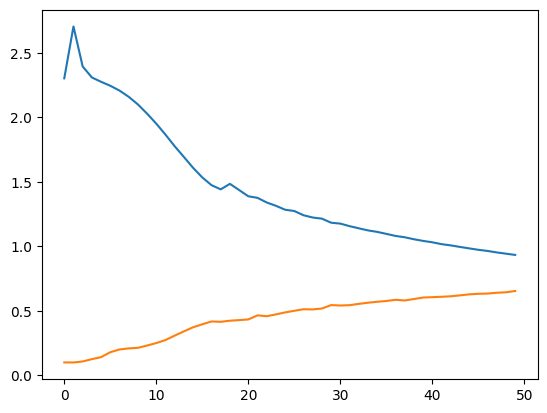

In [19]:
tamanho_entrada = 84 * 84
camada_oculta1 = 128
camada_oculta2 = 64
camada_saida = 10

modelo = MLP(tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida)
perda = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.01)
lista_perdas1, acuracias1 = treino(modelo, otimizador, perda, dados_treino, num_epocas=50)
plt.plot(lista_perdas1, label='Transformada')
plt.plot(acuracias1, label='Transformada')
teste(modelo, dados_teste, rotulos_teste)

Epoca 1/50, Perda: 2.3025646209716797, Acc: 0.1921
Epoca 2/50, Perda: 2.1536686420440674, Acc: 0.23446666666666666
Epoca 3/50, Perda: 1.9399480819702148, Acc: 0.27908333333333335
Epoca 4/50, Perda: 1.7083017826080322, Acc: 0.43605
Epoca 5/50, Perda: 1.4638534784317017, Acc: 0.5017333333333334
Epoca 6/50, Perda: 1.2262141704559326, Acc: 0.5577
Epoca 7/50, Perda: 1.1422213315963745, Acc: 0.5892
Epoca 8/50, Perda: 1.0318257808685303, Acc: 0.57265
Epoca 9/50, Perda: 0.9665467739105225, Acc: 0.6002666666666666
Epoca 10/50, Perda: 0.9284985065460205, Acc: 0.64885
Epoca 11/50, Perda: 0.8590828776359558, Acc: 0.6713
Epoca 12/50, Perda: 0.8538780212402344, Acc: 0.6672166666666667
Epoca 13/50, Perda: 0.8084218502044678, Acc: 0.6882666666666667
Epoca 14/50, Perda: 0.7665995359420776, Acc: 0.6972833333333334
Epoca 15/50, Perda: 0.7331346273422241, Acc: 0.7154166666666667
Epoca 16/50, Perda: 0.7317870855331421, Acc: 0.7467
Epoca 17/50, Perda: 0.6998559236526489, Acc: 0.7398833333333333
Epoca 18/50,

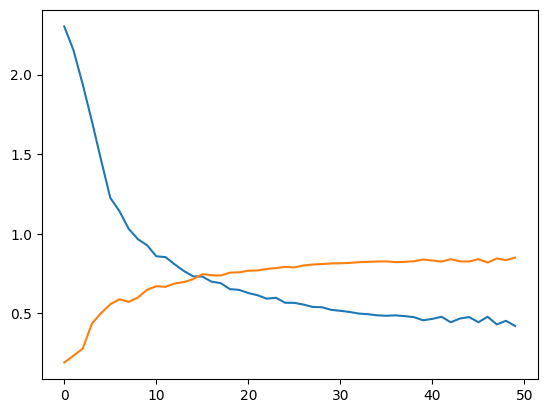

In [20]:
tamanho_entrada = 28 * 28
camada_oculta1 = 128
camada_oculta2 = 64
camada_saida = 10

modelo = MLP(tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida)
perda = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.01)
lista_perdas2, acuracias2 = treino(modelo, otimizador, perda, dados_treino_og, num_epocas=50)
plt.plot(lista_perdas2, label='Original')
plt.plot(acuracias2, label='Original')
teste(modelo, dados_teste_og, rotulos_teste)